In [186]:
"""
This is based off of Katrin's code (from doi:10.1016/S1540-7489(02)80127-4)

This example is from doi:10.1007/BF00807201 where:
- gauze has 1024 meshes/cm2
- temperature varied from 200-900C
- gauze located at 19? mm, 15 mm diameter
- diameter of 15 mm
- atmospheric pressure
- spacetime ranged from 0.00021-.00042s
- The space time is calculated by:
    open area of gauze (15mm) * wire diameter (60 um) and the gas flow rate
- feed composition:
    CH4:O2:Ar ~ 2:1:10
-contact times .21-.42 ms
"""

# load a bunch of stuff
from __future__ import division
# load
import cantera as ct
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
import csv
from pydas.dassl import DASSL
import os
import rmgpy
import rmg
import re
import operator
import pandas as pd
import pylab
from cycler import cycler
import seaborn as sns
import os
%matplotlib inline

# this chemkin file is from the cti generated by rmg
# i only need to import it once
gas = ct.Solution('./chem_annotated.cti','gas')
surf = ct.Interface('./chem_annotated.cti','surface1', [gas])
# cantera files without gas??
gas2 = ct.Solution('./chem_annotated.cti','gas')
gas2.set_multiplier(0.0)
surf2 = ct.Interface('./chem_annotated.cti','surface1', [gas2])

gas3 = ct.Solution('./chem_annotated.cti','gas')
surf3 = ct.Interface('./chem_annotated.cti','surface1', [gas3])

print "This mechanism contains %d gas reactions and %d surface reactions"%(gas.n_reactions, surf.n_reactions)
i_n2 = gas.species_index('N2')
i_ch4 = gas.species_index('CH4(2)')
i_o2 = gas.species_index('O2(3)')
i_co2 = gas.species_index('CO2(4)')
i_h2o = gas.species_index('H2O(5)')
i_h2 = gas.species_index('H2(6)')
i_co = gas.species_index('CO(7)')

errors = []

# unit conversion factors to SI
mm = 0.001
ms = mm
minute = 60.0

#######################################################################
# Input Parameters
#######################################################################
t_in = 1073.15 #K
# t_cat = 1073.15 #K
t_cat = t_in
length = 40 * mm  # Reactor length - gauze at 19mm from the start
diam = 15*mm # Reactor diameter
area = (diam/2.0)**2*np.pi  # Reactor cross section area (area of tube)

mesh = 1024. # mesh size in meshes/cm2
wire = 0.00006 # wire thickness in m

mesh = mesh/(0.01**2) # convert to mesh/m2
holes = np.sqrt(mesh)*diam # number of holes across the diameter
gas_area = ((diam/holes)-wire)**2 # gas area in one hole, meter2
mesh_area = (diam/holes)**2 # total area in one hole, meter2
open_area = gas_area/mesh_area*area # total open gas area in gauze
cat_area = (1-gas_area/mesh_area)*area # total cat surface area in gauze, m2

cat_area_per_vol = cat_area/(open_area*wire)  # Catalyst particle surface area per unit volume in m^-1
contact_time = 0.21 * ms # time in contact with gauze, in seconds
velocity = wire/contact_time  # gas velocity going through gauze, m/s
porosity = 1.  # Monolith channel porosity

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 4001

on_catalyst = 1900
off_catalyst = 1910
dt = 1.0

reactor_len = length/(NReactors-1)
rvol = area * reactor_len * porosity

# catalyst area in one reactor
cat_area = cat_area_per_vol * rvol

mass_flow_rate = velocity * gas.density * area

This mechanism contains 41 gas reactions and 31 surface reactions


In [106]:
def monolithFull(gas,surf,temp,verbose=False,sens=False):
    """
    Verbose prints out values as you go along
    Sens is for sensitivity, in the form [perturbation, reaction #]
    """
    gas.TPX = temp, ct.one_atm, 'CH4(2):0.1, O2(3):0.1, N2:.8'
    temp_cat = temp
    surf.TP = temp_cat, ct.one_atm
    surf.coverages = 'X(1):1.0'
    gas.set_multiplier(1.0)
    
    TDY = gas.TDY
    cov = surf.coverages

    if verbose is True:
        print('    distance       X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2')

    # create a new reactor
    gas.TDY = TDY
    r = ct.IdealGasReactor(gas)
    r.volume = rvol

    # create a reservoir to represent the reactor immediately upstream. Note
    # that the gas object is set already to the state of the upstream reactor
    upstream = ct.Reservoir(gas, name='upstream')

    # create a reservoir for the reactor to exhaust into. The composition of
    # this reservoir is irrelevant.
    downstream = ct.Reservoir(gas, name='downstream')

    # Add the reacting surface to the reactor. The area is set to the desired
    # catalyst area in the reactor.
    rsurf = ct.ReactorSurface(surf, r, A=cat_area)

    # The mass flow rate into the reactor will be fixed by using a
    # MassFlowController object.
    m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

    # We need an outlet to the downstream reservoir. This will determine the
    # pressure in the reactor. The value of K will only affect the transient
    # pressure difference.
    v = ct.PressureController(r, downstream, master=m, K=1e-5)

    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12

    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-10
    sim.atol = 1.0e-18

    gas_names = gas.species_names
    surf_names = surf.species_names
    gas_out = []
    surf_out = []
    dist_array=[]
    T_array = []


    surf.set_multiplier(0.0) #no surface reactions until the gauze
    for n in range(NReactors):
        # Set the state of the reservoir to match that of the previous reactor
        gas.TDY = r.thermo.TDY
        upstream.syncState()
        if n==on_catalyst:
            surf.set_multiplier(1.0)
            if sens is not False:
                surf.set_multiplier(1.0+sens[0],sens[1])
        if n==off_catalyst:
            surf.set_multiplier(0.0)
        sim.reinitialize()
        sim.advance_to_steady_state()
        dist = n * reactor_len * 1.0e3   # distance in mm
        dist_array.append(dist)
        T_array.append(surf.T)
        gas_out.append(gas.X.copy())
        surf_out.append(surf.X.copy())

        if verbose is True:
            if not n % 100:
                print('  {0:10f}  {1:10f}  {2:10f}  {3:10f} {4:10f} {5:10f} {6:10f}'.format(dist, *gas['CH4(2)','O2(3)','H2(6)','CO(7)','H2O(5)','CO2(4)'].X))
                #print(surf.T)
                #print(gas.P)
                #print(surf.coverages)

    gas_out = np.array(gas_out)
    surf_out = np.array(surf_out)
    gas_names = np.array(gas_names)
    surf_names = np.array(surf_names)
    return gas_out, surf_out, gas_names, surf_names, dist_array, T_array

In [105]:
# gas_out, surf_out, gas_names, surf_names, dist_array, T_array = monolithFull(gas,surf,t_in)
a = monolithFull(gas,surf,t_in,verbose=True)

    distance       X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2
    0.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    1.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    2.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    3.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    4.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    5.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    6.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    7.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    8.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    9.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
   10.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
   11.000000  

In [101]:
def monolithNoGas(gas2,surf2,temp,verbose=False):
    gas2.TPX = temp, ct.one_atm, 'CH4(2):0.1, O2(3):0.1, N2:.8'
    temp_cat = temp
    surf2.TP = temp_cat, ct.one_atm
    surf2.coverages = 'X(1):1.0'
    
    gas2.set_multiplier(0.0) # turn gas reactions off

    TDY = gas2.TDY
    cov = surf2.coverages
    if verbose is True:
        print('    distance       X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2')

    # create a new reactor for when gas phase reactions are not included
    gas2.TDY = TDY
    r2 = ct.IdealGasReactor(gas2)
    r2.volume = rvol

    # create a reservoir to represent the reactor immediately upstream. Note
    # that the gas object is set already to the state of the upstream reactor
    upstream2 = ct.Reservoir(gas2, name='upstream')

    # create a reservoir for the reactor to exhaust into. The composition of
    # this reservoir is irrelevant.
    downstream2 = ct.Reservoir(gas2, name='downstream')

    # Add the reacting surface to the reactor. The area is set to the desired
    # catalyst area in the reactor.
    rsurf2 = ct.ReactorSurface(surf2, r2, A=cat_area)

    # The mass flow rate into the reactor will be fixed by using a
    # MassFlowController object.
    m2 = ct.MassFlowController(upstream2, r2, mdot=mass_flow_rate)

    # We need an outlet to the downstream reservoir. This will determine the
    # pressure in the reactor. The value of K will only affect the transient
    # pressure difference.
    v2 = ct.PressureController(r2, downstream2, master=m2, K=1e-5)

    sim2 = ct.ReactorNet([r2])
    sim2.max_err_test_fails = 12

    # set relative and absolute tolerances on the simulation
    sim2.rtol = 1.0e-10
    sim2.atol = 1.0e-18

    gas2_names = gas2.species_names
    surf2_names = surf2.species_names
    gas2_out = []
    surf2_out = []
    dist2_array=[]
    T2_array = []
    surf2.set_multiplier(0.0) #no surface reactions until in the middle of the reactor.
    for n in range(NReactors):
        # Set the state of the reservoir to match that of the previous reactor
        gas2.TDY = r2.thermo.TDY
        upstream2.syncState()
        if n==on_catalyst:
            surf2.set_multiplier(1.0)
            if verbose is True:
                print(surf2.T)
        if n==off_catalyst:
            surf2.set_multiplier(0.0)
            if verbose is True:
                print(surf2.T)
        sim2.reinitialize()
        sim2.advance_to_steady_state()
        dist2 = n * reactor_len * 1.0e3   # distance in mm
        dist2_array.append(dist2)
        T2_array.append(surf2.T)
        gas2_out.append(gas2.X.copy())
        surf2_out.append(surf2.X.copy())

        if verbose is True:
            if not n % 100:
                print('  {0:10f}  {1:10f}  {2:10f}  {3:10f} {4:10f} {5:10f} {6:10f}'.format(dist2, *gas2['CH4(2)','O2(3)','H2(6)','CO(7)','H2O(5)','CO2(4)'].X))
                #print(surf2.T)

    gas2_out = np.array(gas2_out)
    surf2_out = np.array(surf2_out)
    gas2_names = np.array(gas2_names)
    surf2_names = np.array(surf2_names)
    return gas2_out, surf2_out, gas2_names, surf2_names, dist2_array, T2_array


In [102]:
# gas2_out, surf2_out, gas2_names, surf2_names, dist2_array, T2_array = monolithNoGas(gas2,surf2,t_in)
b = monolithNoGas(gas,surf,t_in,True)

    distance       X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2
    0.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    1.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    2.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    3.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    4.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    5.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    6.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    7.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    8.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
    9.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
   10.000000    0.100000    0.100000    0.000000   0.000000   0.000000   0.000000
   11.000000  

In [14]:
def plot(a,b):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
    gas2_out, surf2_out, gas2_names, surf2_names, dist2_array, T2_array = b
    
    # configure the plot
    fig, axs = plt.subplots(1,2)

    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))                          

    #PLOT WITH GAS PHASE REACTIONS INCLUDED
    for i in range(len(gas_out[0,:])):
        if gas_out[:,i].max() > 5.e-3:
#             print(gas_names[i])
            axs[0].plot(dist_array, gas_out[:,i], label=gas_names[i])
            species_name = gas_names[i]
            if species_name.endswith(')'):
                            if species_name[-3] == '(':
                                species_name = species_name[0:-3]
                            else:
                                species_name = species_name[0:-4]
            if species_name == "O2":
                axs[0].annotate("O$_2$", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+gas_out[:,i][3800]/100.0), va =('bottom'), ha = ('center'))
            elif species_name == "CO2":
                axs[0].annotate("CO$_2$", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+gas_out[:,i][3800]/10.0), va =('top'), ha = ('center'))
            elif species_name == "CO":
                axs[0].annotate("CO", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+0.001), va =('bottom'), ha = ('center'))
            elif species_name == "CH2O":
                axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+0.001), va =('bottom'), ha = ('center'))    
            elif species_name == "CH4":
                axs[0].annotate("CH$_4$", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+gas_out[:,i][3800]/100.0), va =('bottom'), ha = ('center'))  
            elif species_name == "H2O":
                axs[0].annotate("H$_2$O", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+gas_out[:,i][3800]/40.0), va =('top'), ha = ('center'))   
            else:                     
                axs[0].annotate(species_name, fontsize=12, xy=(dist_array[-1], gas_out[:,i][-1]+gas_out[:,i][-1]/10.0), va =('top'), ha = ('center'))
        else:
            axs[0].plot(0,0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))  
    #Plot two temperatures (of gas-phase and surface vs only surface.)
    axs[1].plot(dist_array, T_array, label="surface + gas reactions")
    axs[1].plot(dist_array, T2_array, "--", label="surface reactions only")


    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))
    #PLOT WITHOUT GAS PHASE REACTIONS
    for i in range(len(gas2_out[0,:])):
        if gas2_out[:,i].max() > 1.e-3:
            axs[0].plot(dist2_array, gas2_out[:,i], '--', label=gas2_names[i])
        else:
            axs[0].plot(0,0)  
    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))    


    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[-0.02,0.2], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[-0.02,0.2], linestyle='--', color='xkcd:grey')  
    axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.175), va =('bottom'), ha = ('center'))
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[600.0,2000], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[600.0,2000], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1665), va =('bottom'), ha = ('center'))

    for item in (axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
        item.set_fontsize(12)

    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(-0.02,0.2); axs[1].set_ylim(600.0,2000)
    axs[0].set_xlim(0.0,length/mm); axs[1].set_xlim(0.0,length/mm)
    axs[0].set_xlabel('Distance (mm)', fontsize=13); axs[1].set_xlabel('Distance (mm)', fontsize=13); #axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('Gas-phase mole fractions', fontsize=13); axs[1].set_ylabel('Temperature (K)', fontsize=13)
    #fig.tight_layout()
    #axs[1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    #axs[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    #axs[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    fig.set_figheight(6)
    fig.set_figwidth(13)
    
    temperature = np.round(T_array[0],0)
    # uncomment to save figure
    fig.savefig('T' + str(temperature)+ 'K.png', bbox_inches='tight')

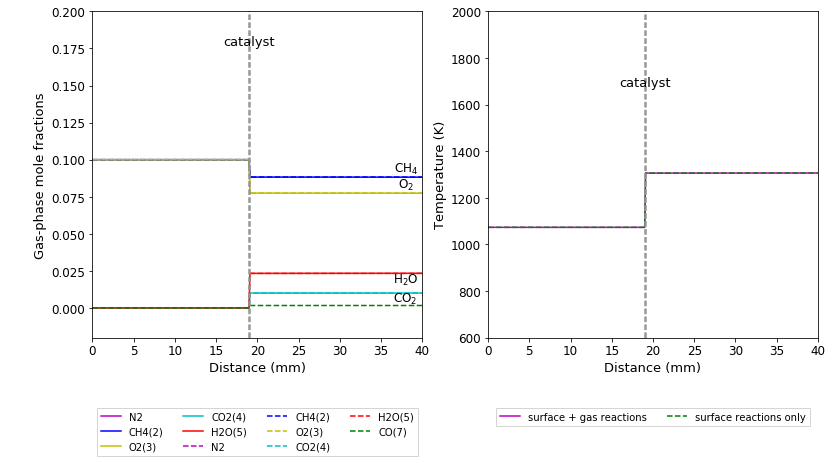

In [15]:
plot(a,b)

In [16]:
def plotZoom(a,b):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
    gas2_out, surf2_out, gas2_names, surf2_names, dist2_array, T2_array = b
    # configure the plot
    fig, axs = plt.subplots(1,2)

    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))                          

    #PLOT WITH GAS PHASE REACTIONS INCLUDED
    for i in range(len(gas_out[0,:])):
        if gas_out[:,i].max() > 5.e-3:
#             print(gas_names[i])
            axs[0].plot(dist_array, gas_out[:,i], label=gas_names[i])
            species_name = gas_names[i]
            if species_name.endswith(')'):
                            if species_name[-3] == '(':
                                species_name = species_name[0:-3]
                            else:
                                species_name = species_name[0:-4]
            if species_name == "O2":
                axs[0].annotate("O$_2$", fontsize=12, xy=(dist_array[1945], gas_out[:,i][1945]+gas_out[:,i][1945]/100.0), va =('bottom'), ha = ('center'))
            elif species_name == "CO2":
                axs[0].annotate("CO$_2$", fontsize=12, xy=(dist_array[1945], gas_out[:,i][1945]+gas_out[:,i][1945]/10.0), va =('top'), ha = ('center'))
            elif species_name == "CO":
                axs[0].annotate("CO", fontsize=12, xy=(dist_array[1945], gas_out[:,i][1945]+0.001), va =('bottom'), ha = ('center'))
            elif species_name == "CH2O":
                axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[1945], gas_out[:,i][1945]+0.001), va =('bottom'), ha = ('center'))    
            elif species_name == "CH4":
                axs[0].annotate("CH$_4$", fontsize=12, xy=(dist_array[1945], gas_out[:,i][1945]+gas_out[:,i][1945]/100.0), va =('bottom'), ha = ('center'))  
            elif species_name == "H2O":
                axs[0].annotate("H$_2$O", fontsize=12, xy=(dist_array[1945], gas_out[:,i][1945]+gas_out[:,i][1945]/40.0), va =('top'), ha = ('center'))   
            else:                     
                axs[0].annotate(species_name, fontsize=12, xy=(dist_array[-1], gas_out[:,i][-1]+gas_out[:,i][-1]/10.0), va =('top'), ha = ('center'))
        else:
            axs[0].plot(0,0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))  
    #Plot two temperatures (of gas-phase and surface vs only surface.)
    axs[1].plot(dist_array, T_array, label="surface + gas reactions")
    axs[1].plot(dist_array, T2_array, "--", label="surface reactions only")


    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))
    #PLOT WITHOUT GAS PHASE REACTIONS
    for i in range(len(gas2_out[0,:])):
        if gas2_out[:,i].max() > 1.e-3:
            axs[0].plot(dist2_array, gas2_out[:,i], '--', label=gas2_names[i])
        else:
            axs[0].plot(0,0)  
    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))    


    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[-0.02,0.2], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[-0.02,0.2], linestyle='--', color='xkcd:grey')  
    axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.175), va =('bottom'), ha = ('left'))
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[600.0,2000], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[600.0,2000], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1800), va =('bottom'), ha = ('left'))

    for item in (axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
        item.set_fontsize(12)

    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(-0.02,0.2); axs[1].set_ylim(600.0,2000)
    axs[0].set_xlim(18.9,19.5); axs[1].set_xlim(18.9,19.5)
    axs[0].set_xlabel('Distance (mm)', fontsize=13); axs[1].set_xlabel('Distance (mm)', fontsize=13); #axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('Gas-phase mole fractions', fontsize=13); axs[1].set_ylabel('Temperature (K)', fontsize=13)
    #fig.tight_layout()
    #axs[1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    #axs[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    #axs[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    fig.set_figheight(6)
    fig.set_figwidth(13)

    temperature = np.round(T_array[0],0)
    # uncomment to save figure
    fig.savefig('T' + str(temperature)+ 'Kzoom.png', bbox_inches='tight')

    #axs[0].grid(); axs[1].grid(); #axs[1,0].grid(); axs[1,1].grid()

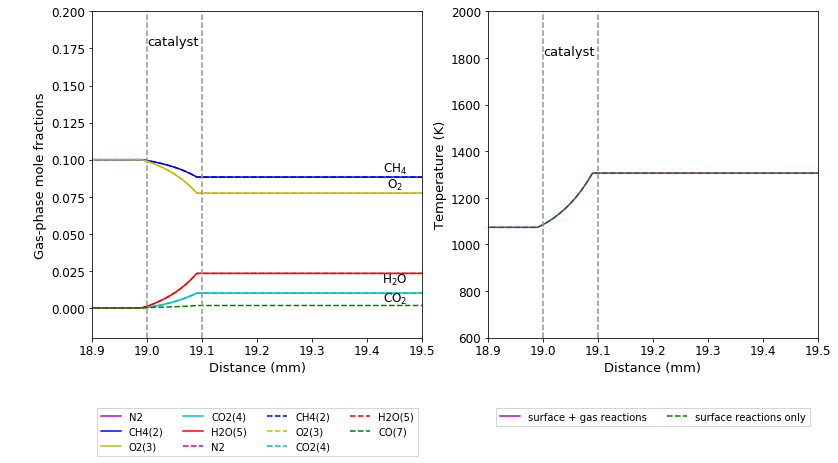

In [17]:
plotZoom(a,b)

Unable to run simulation at 900 K
Unable to run simulation at 1250 K


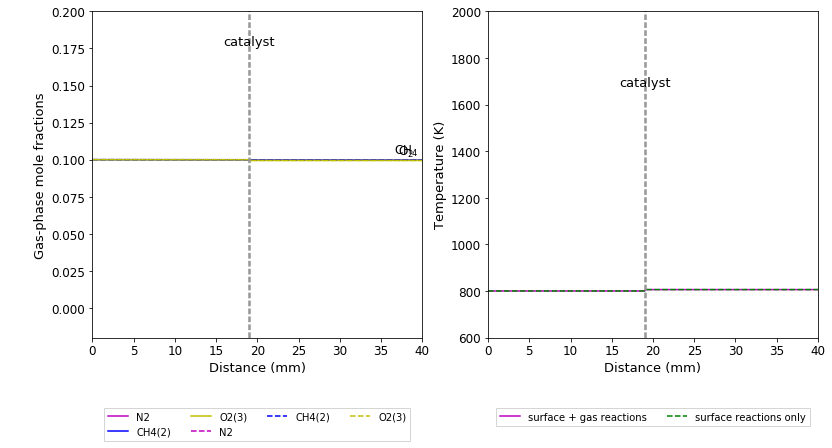

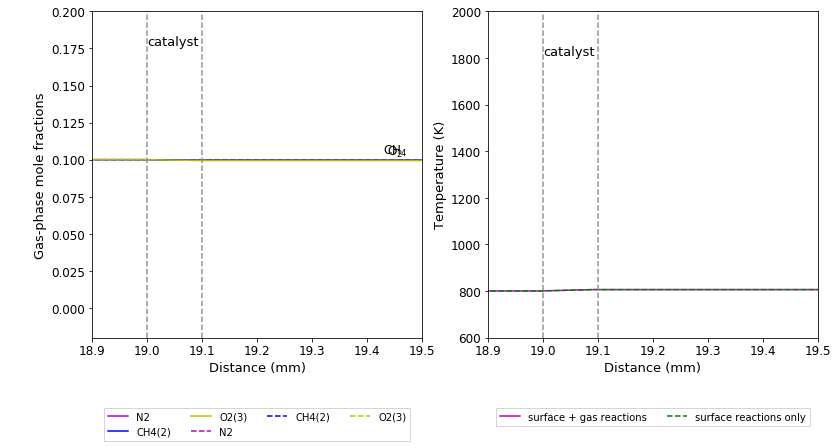

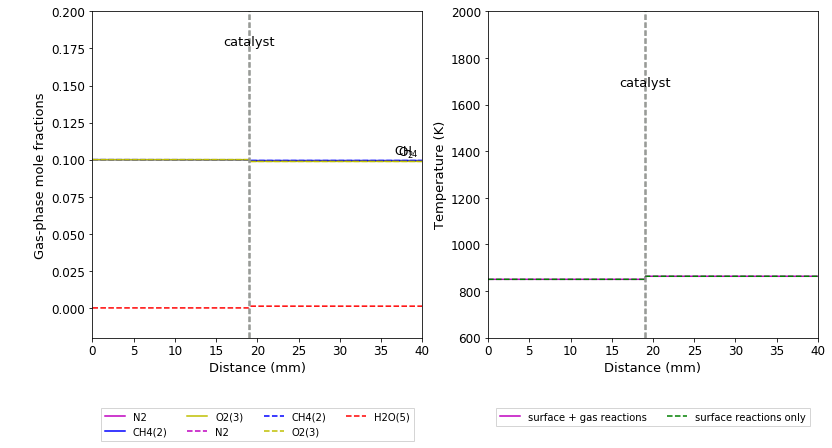

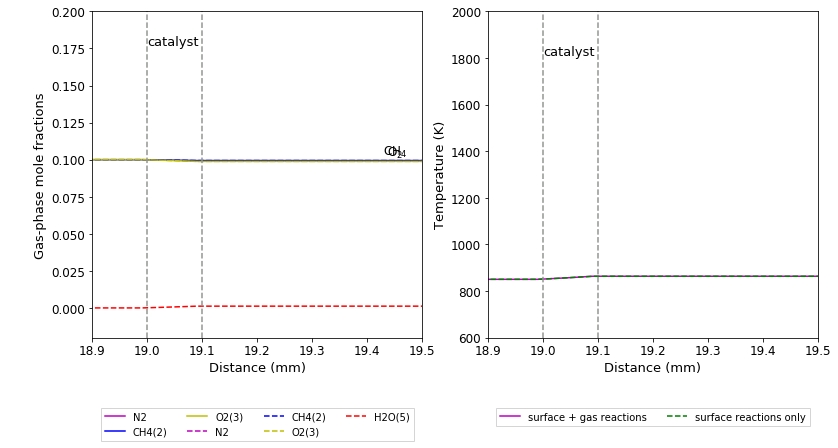

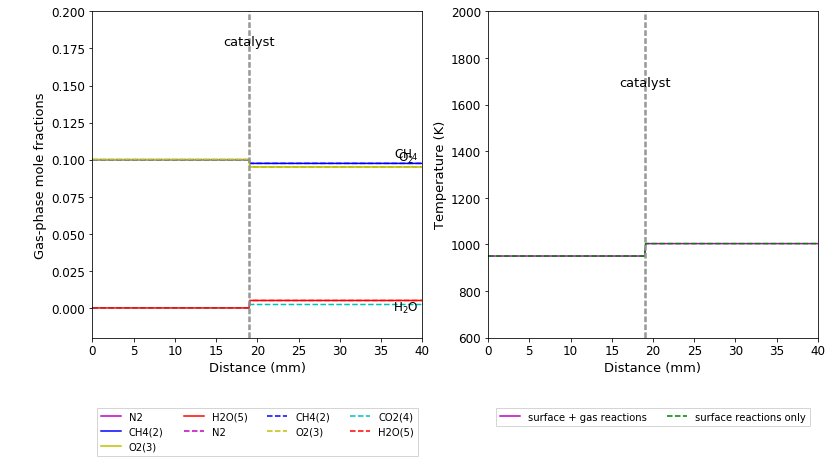

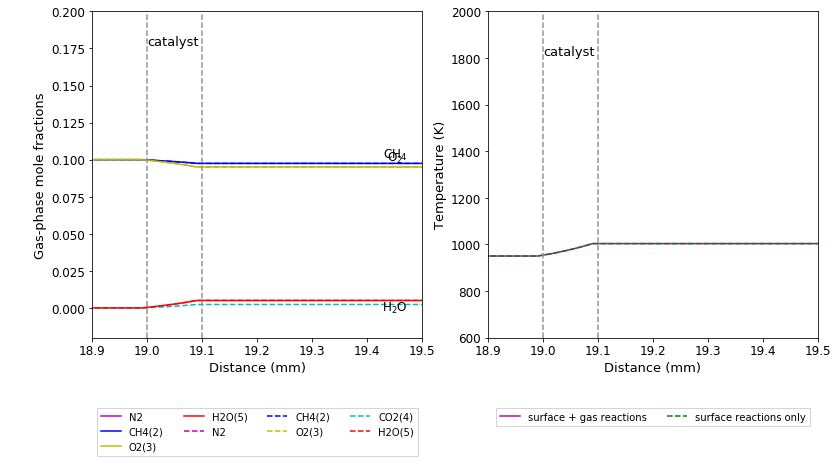

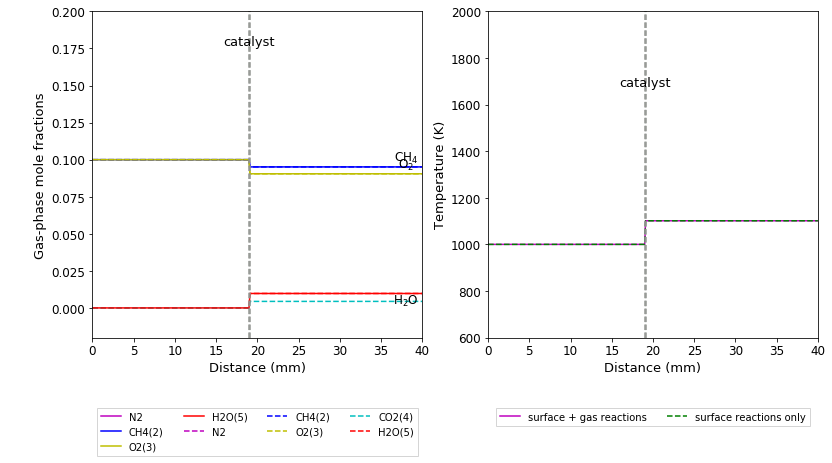

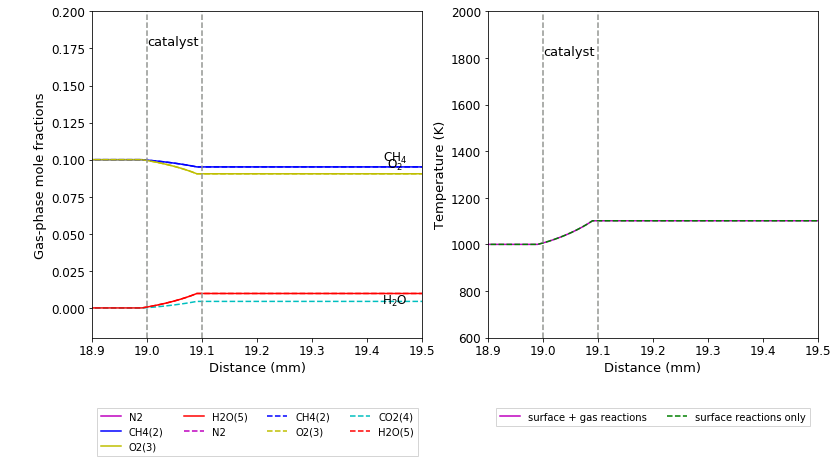

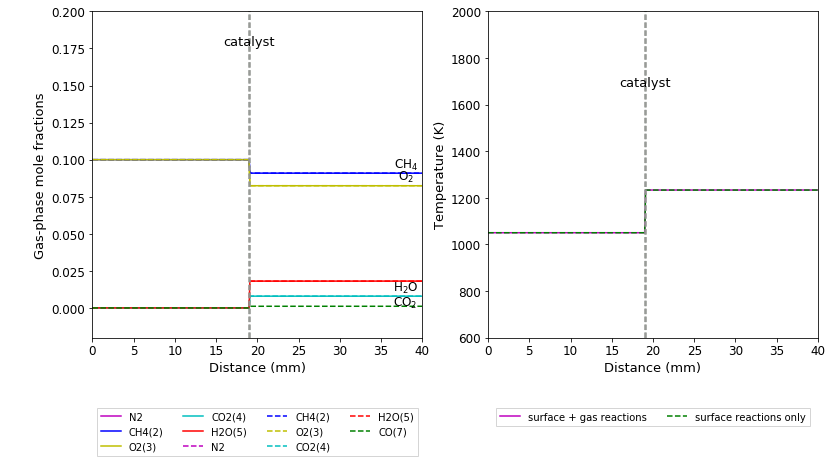

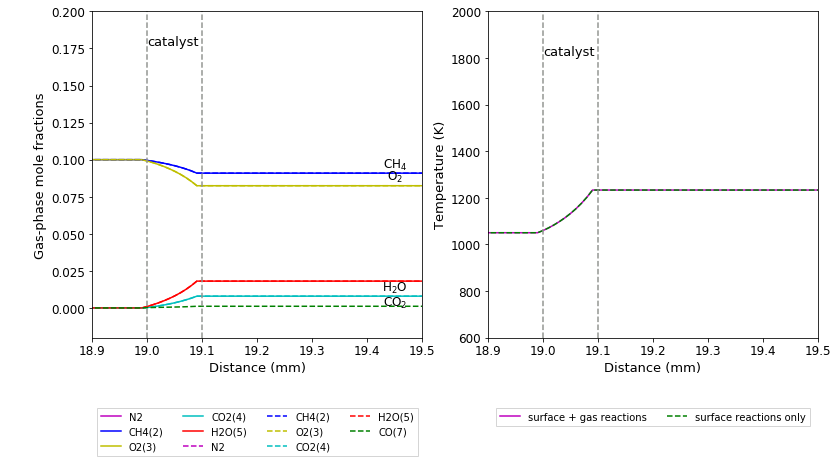

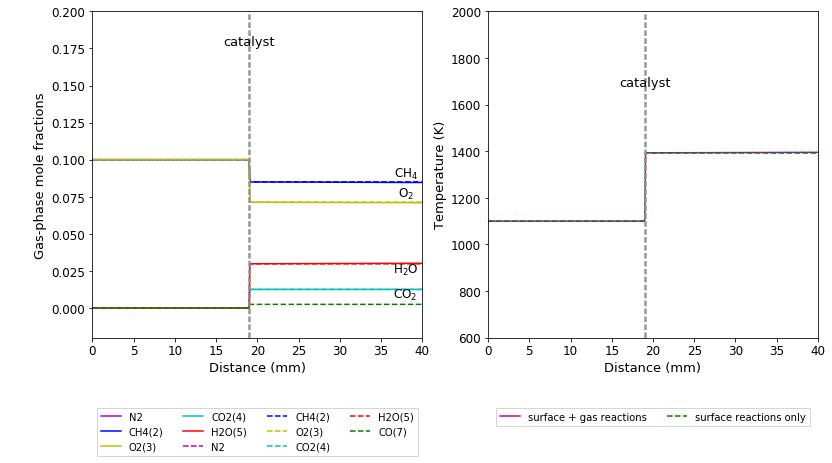

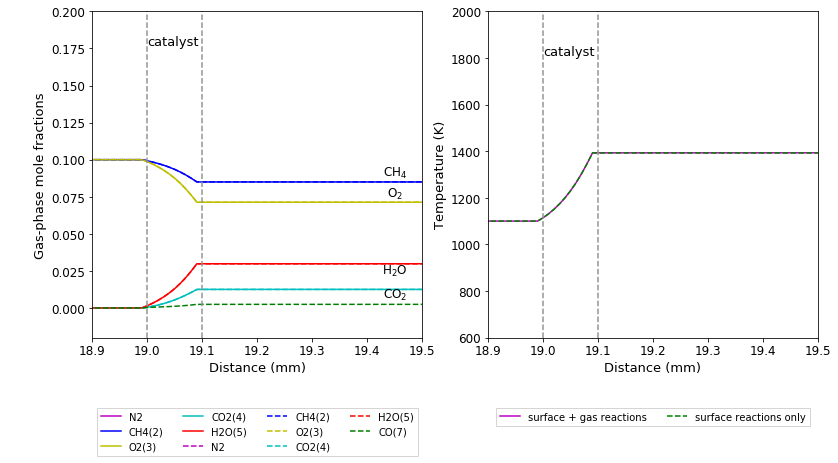

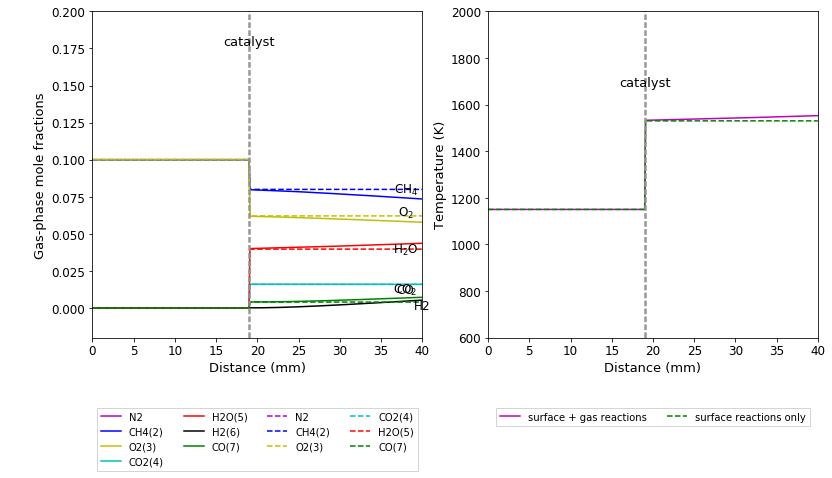

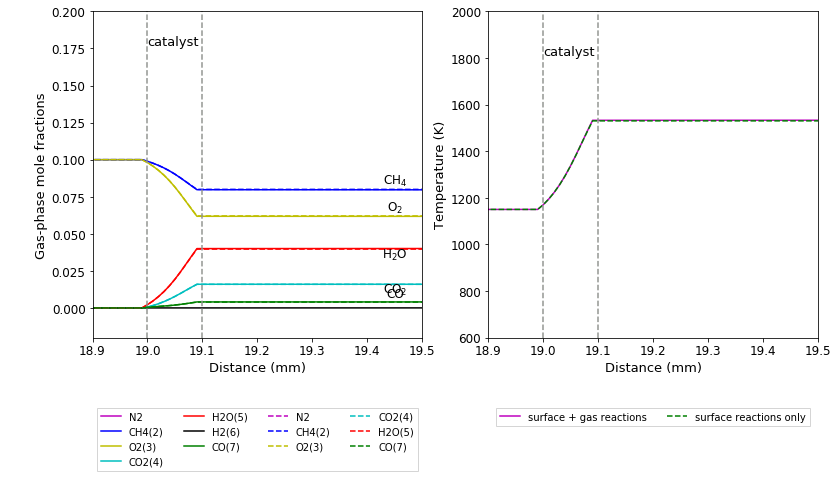

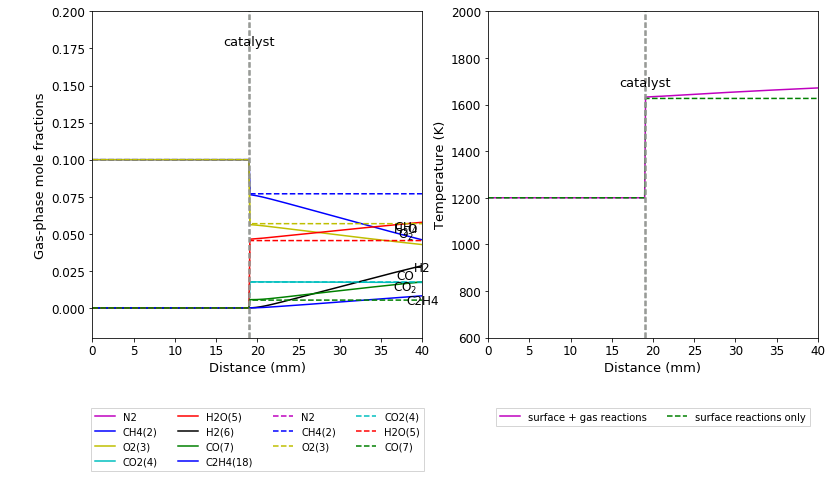

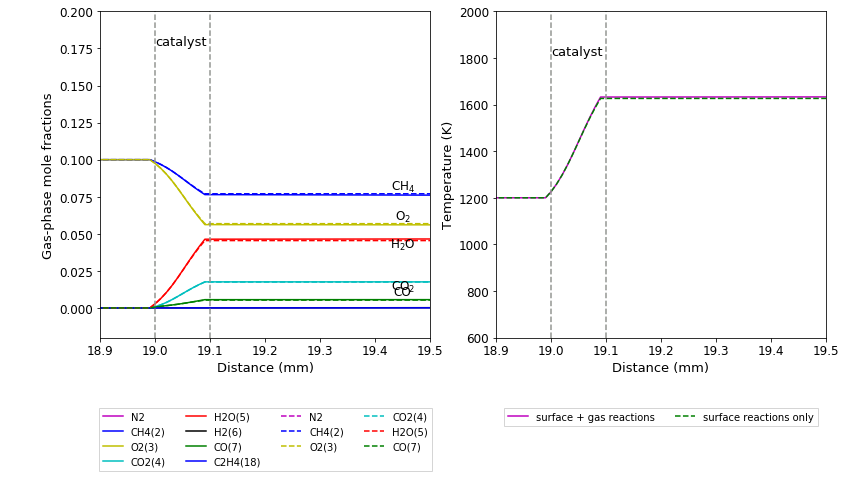

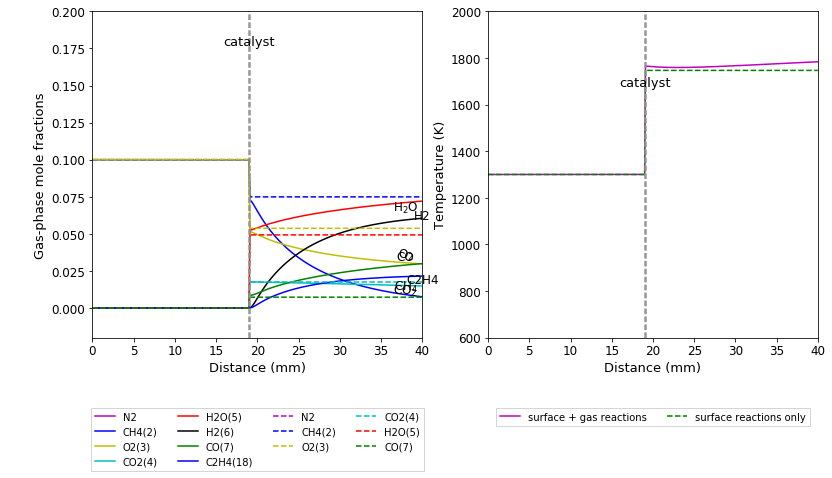

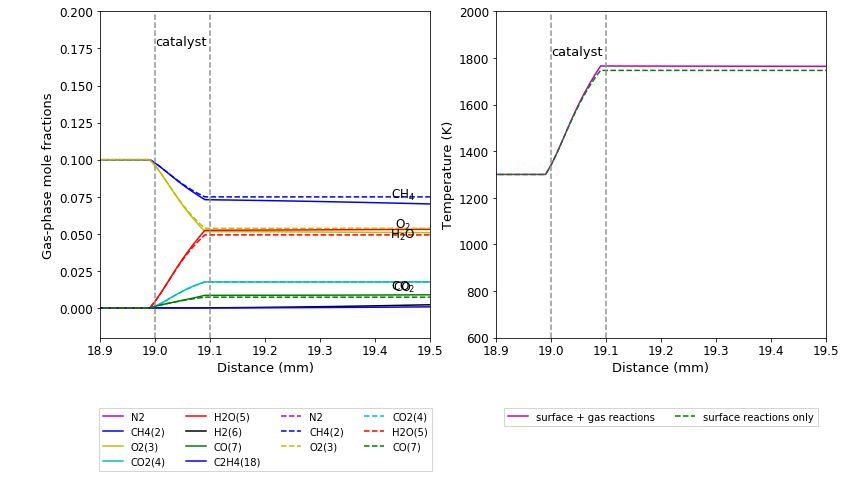

In [18]:
# at different temperatures
t_in = np.linspace(800,1300,11)

data = []

for t in t_in:
    try:
        a = monolithFull(gas,surf,t,False)
        b = monolithNoGas(gas2,surf2,t,False)
        plot(a,b)
        plotZoom(a,b)
        
        gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
        gas2_out, surf2_out, gas2_names, surf2_names, dist2_array, T2_array = b
    
        data.append([t,[gas_out,gas_names,dist_array,T_array],[gas2_out, gas2_names, dist2_array, T2_array]])
    except:
        print('Unable to run simulation at {:.0f} K'.format(t))
        errors.append(t)
        pass
    

In [37]:
ch4=[];o2=[];co2=[];h2o=[];h2=[];co=[];ch2o=[];ch3oh=[]

for t in data:
    gas_out,gas_names,dist_array,T_array = t[1]
    gas2_out, gas2_names, dist2_array, T2_array = t[2]
    ch4.append([t[0],gas_out[:,2],gas2_out[:,2]])
    o2.append([t[0],gas_out[:,3],gas2_out[:,3]])
    co2.append([t[0],gas_out[:,4],gas2_out[:,4]])
    h2o.append([t[0],gas_out[:,5],gas2_out[:,5]])
    h2.append([t[0],gas_out[:,6],gas2_out[:,6]])
    co.append([t[0],gas_out[:,7],gas2_out[:,7]])
    ch2o.append([t[0],gas_out[:,9],gas2_out[:,9]])
    ch3oh.append([t[0],gas_out[:,14],gas2_out[:,14]])

ch2o


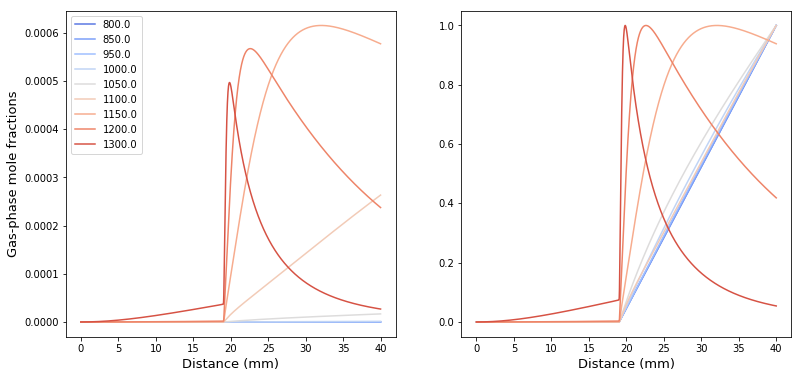

In [83]:
print 'ch2o'
fig, axs = plt.subplots(1,2)
num_lines = len(ch2o)
sns.set_palette(sns.color_palette("coolwarm",num_lines))
for x in range(len(ch2o)):
    axs[0].plot(dist_array, ch2o[x][1], label=ch2o[x][0])
    axs[1].plot(dist_array, ch2o[x][1]/np.max(ch2o[x][1]), label=ch2o[x][0])

axs[0].legend()
axs[0].set_ylabel('Gas-phase mole fractions', fontsize=13);
axs[0].set_xlabel('Distance (mm)', fontsize=13);
axs[1].set_xlabel('Distance (mm)', fontsize=13); 
fig.set_figheight(6)
fig.set_figwidth(13)

ch3oh


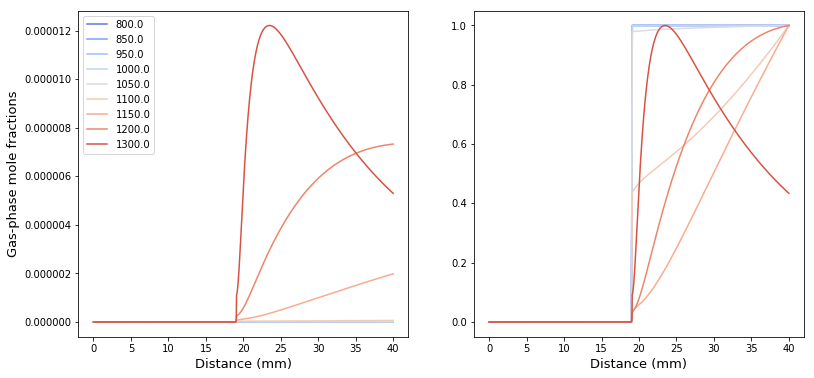

In [84]:
print 'ch3oh'
fig, axs = plt.subplots(1,2)
num_lines = len(ch3oh)
sns.set_palette(sns.color_palette("coolwarm",num_lines))
for x in range(len(ch3oh)):
    axs[0].plot(dist_array, ch3oh[x][1], label=ch3oh[x][0])
    axs[1].plot(dist_array, ch3oh[x][1]/np.max(ch3oh[x][1]), label=ch3oh[x][0])
axs[0].legend()
axs[0].set_ylabel('Gas-phase mole fractions', fontsize=13);
axs[0].set_xlabel('Distance (mm)', fontsize=13);
axs[1].set_xlabel('Distance (mm)', fontsize=13); 
fig.set_figheight(6)
fig.set_figwidth(13)

In [112]:
surf.reaction_equation(1)

'O2(3) + 2 X(1) <=> 2 OX(20)'

In [166]:
##################
## SENSITIVITY
##################

def sensitivity(gas,surf,old_data,temp,dk):
    """
    Function to get sensitivity, but running additional simulations and comparing
    to the original simulation (data) to get a numberical value for sensitivity.
    
    old_data is an array with the original simulation output.
    
    Has multiple ways to calculate sensitivity.  You can use all at once, but was
    written so that the other ways could be commented out.
    """
    rxns = []
    sens1 = []
    sens2 = []
    sens3 = []
    
    gas_out_data,gas_names_data,dist_array_data,T_array_data = old_data
    reference = []
    for a in range(len(gas_names_data)):
        reference.append([gas_names_data[a],[gas_out_data[:,a]]])
    
    #####################################
    ## Sensitivity definition 1:
    ##
    ## defining by amt of ch4 depletion
    ## from the beginning of the tube to
    ## the end of the tube
    ## 
    ## negative sensitivity is 'faster' depletion
    #####################################
    for x in reference:
        if x[0]=='CH4(2)':
            reference_ch4_depletion = x[1][0][0]-x[1][0][-1]
    
    #####################################
    ## Sensitivity definition 2:
    ##
    ## defining by the amt of o2 depletion
    ## from the beginning of the tube to
    ## the end of the tube
    ##
    ## negative sensitivity is 'faster' depletion
    #####################################
    for x in reference:
        if x[0]=='O2(3)':
            reference_o2_depletion = x[1][0][0]-x[1][0][-1]
    
    #####################################
    ## Sensitivity definition 3:
    ##
    ## defining by the amt of ch2o and ch3oh
    ## products formed at the end of the tube
    ##
    ## might not be the best way to do this;
    ## need to look at current methods for
    ## creating those products
    ##
    ## maybe integrate under mol fraction instead?
    ##
    ## negative sensitivity is 'faster' product formation
    ## (As of current def of sum of prod at end of tube)
    #####################################
    for x in reference:
        if x[0]=='CH2O(9)':
            reference_ch2o = x[1][0][-1]
        if x[0]=='CH3OH(14)':
            reference_ch3oh = x[1][0][-1]
    reference_products = reference_ch2o+reference_ch3oh
    
    
    # run the simulations
    for rxn in range(surf.n_reactions):
        c = monolithFull(gas,surf,temp,sens=[dk,rxn])
        gas_out, surf_out, gas_names, surf_names, dist_array, T_array = c
        
        # uncomment if sensitivity for surface only reactions are wanted
#         d = monolithNoGas(gas,surf,temp,sens=[dk,rxn])
#         gas2_out, surf2_out, gas2_names, surf2_names, dist2_array, T2_array = d
        
        new_amts = []
        for a in range(len(gas_names)):
            new_amts.append([gas_names[a],[gas_out[:,a]]])
        
        #####################################
        ## Sensitivity definition 1:
        #####################################
        for x in new_amts:
            if x[0]=='CH4(2)':
                new_ch4_depletion = x[1][0][0]-x[1][0][-1]
        Sens1 = (reference_ch4_depletion-new_ch4_depletion)/(reference_ch4_depletion*dk)
        sens1.append(Sens1)
        print "%d %s %.3F"%(rxn,surf.reaction_equations()[rxn],Sens1)
        
        #####################################
        ## Sensitivity definition 2:
        #####################################
        for x in new_amts:
            if x[0]=='O2(3)':
                new_o2_depletion = x[1][0][0]-x[1][0][-1]
        Sens2 = (reference_o2_depletion-new_o2_depletion)/(reference_o2_depletion*dk)
        sens2.append(Sens2)
        print "%d %s %.3F"%(rxn,surf.reaction_equations()[rxn],Sens2)

        #####################################
        ## Sensitivity definition 3:
        #####################################
        for x in new_amts:
            if x[0]=='CH2O(9)':
                new_ch2o = x[1][0][-1]
            if x[0]=='CH3OH(14)':
                new_ch3oh = x[1][0][-1]
        new_products = new_ch2o+new_ch3oh
        Sens3 = (reference_products-new_products)/(reference_products*dk)
        sens3.append(Sens3)
        print "%d %s %.3F"%(rxn,surf.reaction_equations()[rxn],Sens3)

        rxns.append(surf.reaction_equations()[rxn])
    return rxns,sens1,sens2,sens3

In [169]:
# Set the value of the perturbation
dk = 1.0e-2

# this takes the longest
sens_by_temp = []
for t in range(len(data)):
    print data[t][0]
    reactions,sensitivity1,sensitivity2,sensitivity3=sensitivity(gas,surf,data[t][1],data[t][0],dk)
    sens_by_temp.append([data[t][0],sensitivity1,sensitivity2,sensitivity3])

800.0
0 CH4(2) + X(1) <=> CH4X(56) -0.000
0 CH4(2) + X(1) <=> CH4X(56) -0.000
0 CH4(2) + X(1) <=> CH4X(56) 0.000
1 O2(3) + 2 X(1) <=> 2 OX(20) 0.993
1 O2(3) + 2 X(1) <=> 2 OX(20) 1.007
1 O2(3) + 2 X(1) <=> 2 OX(20) 0.638
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) -0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.061
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.067
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.081
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.041
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) -0.774
6 OH(17) + X(1) <=> HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.204
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
8 CH4(2) + 2 X(1) <=>

1 O2(3) + 2 X(1) <=> 2 OX(20) 1.074
1 O2(3) + 2 X(1) <=> 2 OX(20) 1.086
1 O2(3) + 2 X(1) <=> 2 OX(20) 1.278
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) -0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) -0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.547
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.452
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.458
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -3.636
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) -0.029
6 OH(17) + X(1) <=> HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.895
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(

2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) -0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.265
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.848
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.811
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -8.869
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) -0.001
6 OH(17) + X(1) <=> HOX(22) -0.001
6 OH(17) + X(1) <=> HOX(22) -0.001
6 OH(17) + X(1) <=> HOX(22) -0.413
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX

3 CH3(10) + X(1) <=> CH3X(21) 0.004
3 CH3(10) + X(1) <=> CH3X(21) 0.001
3 CH3(10) + X(1) <=> CH3X(21) -0.004
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -3.354
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -1.986
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) 2.489
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.026
6 OH(17) + X(1) <=> HOX(22) -0.013
6 OH(17) + X(1) <=> HOX(22) 0.020
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.001
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.001
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) 0.001
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) 0.000
10 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) 0.000
10 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) 0.000


4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -0.298
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -0.292
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) 3.478
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.022
6 OH(17) + X(1) <=> HOX(22) -0.021
6 OH(17) + X(1) <=> HOX(22) 0.252
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) 0.005
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) 0.000
10 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) 0.001
10 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) 0.001
10 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) -0.007
11 H(12) + X(1) <=> HX(19) 0.000
11 H(12) + X(1) <=> HX(19) 0

In [219]:
species_dict = rmgpy.data.kinetics.KineticsLibrary().getSpecies('species_dictionary.txt')
keys = species_dict.keys()

# get the first listed smiles string for each molecule
smile = []
for s in species_dict:
    smile.append(species_dict[s].molecule[0])
    if len(species_dict[s].molecule) is not 1:
        print 'There are %d dupllicate smiles for %s:'%(len(species_dict[s].molecule),s)
        for a in range(len(species_dict[s].molecule)):
            print '%s'%(species_dict[s].molecule[a])
            
# translate the molecules from above into just smiles strings
smiles = []
for s in smile:
    smiles.append(s.toSMILES())
    
names = dict(zip(keys,smiles))

rxns_translated = []

# now replace each molecule with smiles
for x in reactions:
    for key, smile in names.iteritems():
        x = re.sub(re.escape(key), smile, x)
    rxns_translated.append(x)

def export(rxns_translated,temp,sens_vals,sens_type=1):
    answer = dict(zip(rxns_translated, sens_vals))
    sorted_answer = sorted(answer.items(), key=operator.itemgetter(1), reverse=False)
    # for x in sorted_answer:
    #     print '%s %.4f'%(x)
    
    # write to csv file
    (pd.DataFrame.from_dict(data=sorted_answer, orient='columns')
    .to_csv('dict_{}K_{}.csv'.format(temp,sens_type), header=False))

In [221]:
# export everything
for x in sens_by_temp:
    for s in range(len(x)-1):
        export(rxns_translated,x[0],x[s+1],s+1)

In [194]:
# if there are errors in generating models, print to a separate text file what they are
if len(errors)==0:
    try:
        os.remove('errors.txt')
    except:
        pass
if len(errors) != 0:
    with open('errors.txt','w') as f:
        f.write(str('Error at temperatures: '))
        for x in range(len(errors)):
            f.write(str(errors[x]))
            if x != len(errors)-1:
                f.write(str(', '))

# Batch reactor

plt.semilogy(surf.reverse_rates_of_progress,'.')

for i in surf.reverse_rates_of_progress.argsort()[:-5:-1]:
    print i, surf.reaction_equation(i)